<a href="https://colab.research.google.com/github/nescoba/portafolio/blob/main/alternative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# pip install itscalledsoccer

     |████████████████████████████████| 61 kB 2.6 MB/s 
     |████████████████████████████████| 11.5 MB 7.6 MB/s 
     |████████████████████████████████| 893 kB 36.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: CacheControl
    Found existing installation: CacheControl 0.12.10
    Uninstalling CacheControl-0.12.10:
      Successfully uninstalled CacheControl-0.12.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have fo

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
sns.set()

In [3]:
from itscalledsoccer.client import AmericanSoccerAnalysis

asa_client = AmericanSoccerAnalysis() 

Gathering all players
Gathering all teams
Gathering all stadia
Gathering all managers
Gathering all referees
Finished initializing client


In [4]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
def construct_time_series_date(team_id, date):
    seasons = asa_client.get_game_xgoals(leagues='mls')
    seasons.loc[:, 'date_formated'] = pd.to_datetime(seasons['date_time_utc'])
    seasons = seasons[seasons['date_formated'] < date]

    seasons_team = seasons[(seasons['home_team_id']==team_id) | (seasons['away_team_id']==team_id)]
    team_home = seasons_team[seasons_team['home_team_id']==team_id]
    team_away = seasons_team[seasons_team['away_team_id']==team_id]

    team_home.loc[:,'teamxgoals'] = team_home['home_team_xgoals']
    team_away.loc[:,'teamxgoals'] = team_away['away_team_xgoals']

    team_home.loc[:,'teamgoals'] = team_home['home_goals']
    team_away.loc[:,'teamgoals'] = team_away['away_goals']

    team_home.loc[:,'oppoxgoals'] = team_home['away_team_xgoals']
    team_away.loc[:,'oppoxgoals'] = team_away['home_team_xgoals']

    team_home.loc[:,'oppogoals'] = team_home['away_goals']
    team_away.loc[:,'oppogoals'] = team_away['home_goals']

    team_home_red = team_home.loc[:, ['teamgoals', 'teamxgoals', 'oppoxgoals', 'oppogoals', 'date_formated']]
    team_away_red = team_away.loc[:, ['teamgoals', 'teamxgoals', 'oppoxgoals', 'oppogoals', 'date_formated']]

    team_red = pd.merge(team_home_red, team_away_red, how='outer')

    team_red = team_red.sort_values(by='date_formated')

    return team_red

In [6]:
def probs_game(home_id, away_id, date, arg):
    home_df = construct_time_series_date(home_id, pd.to_datetime(date))
    away_df = construct_time_series_date(away_id, pd.to_datetime(date))

    hteam_series = pd.Series(home_df['teamxgoals'].values, index=home_df['date_formated'])

    try:
        hmod = sm.tsa.ARIMA(hteam_series, order = (0,1,1))
        hres = hmod.fit()
        hlambda = hres.predict(start=(len(hteam_series)), end=(len(hteam_series)+0)).values
    except:
        try:
            hlambda = home_df.loc[len(home_df) -1 ,'teamxgoals']
        except:
            hlambda = 0.01


    ateam_series = pd.Series(away_df['teamxgoals'].values, index=away_df['date_formated'])
    
    try:
        amod = sm.tsa.ARIMA(ateam_series, order = (0,1,1))
        ares = amod.fit()
        alambda = ares.predict(start=(len(ateam_series)), end=(len(ateam_series)+0)).values
    except:
        try:
            alambda = away_df.loc[len(away_df) - 1, 'teamxgoals']
        except:
            alambda= 0.01


    n_simulations = 10000
    n_home = 0
    n_draw = 0
    n_away = 0

    for n in range(n_simulations):
        home_score = np.random.poisson(max(hlambda, 0.01))
        away_score = np.random.poisson(max(alambda, 0.01))
        if home_score > away_score:
            n_home += 1
        elif home_score < away_score:
            n_away += 1
        else:
            n_draw += 1 

    return (n_home / n_simulations, n_draw / n_simulations, n_away / n_simulations, arg)

In [7]:
nyc_hist = construct_time_series_date('Vj58weDM8n', '2022-03-10')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [8]:
ts = nyc_hist['teamxgoals']

In [9]:
mod = sm.tsa.ARIMA(ts, order = (5,1,0))
res = mod.fit()
print(res.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.teamxgoals   No. Observations:                  243
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -287.957
Method:                       css-mle   S.D. of innovations              0.789
Date:                Thu, 10 Mar 2022   AIC                            589.914
Time:                        14:10:13   BIC                            614.365
Sample:                             1   HQIC                           599.763
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               3.186e-05      0.013      0.002      0.998      -0.025       0.025
ar.L1.D.teamxgoals    -0.8844      0.062    -14.212      0.000      -1.006      -0.762
ar.L2.D.teamxgoals  

In [10]:
mod = sm.tsa.ARIMA(ts, order = (5,1,5))
res = mod.fit()
print(res.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.teamxgoals   No. Observations:                  243
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -272.250
Method:                       css-mle   S.D. of innovations              0.726
Date:                Thu, 10 Mar 2022   AIC                            568.500
Time:                        14:10:20   BIC                            610.417
Sample:                             1   HQIC                           585.384
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0011      0.001      1.466      0.144      -0.000       0.003
ar.L1.D.teamxgoals    -1.1663      1.206     -0.967      0.334      -3.530       1.197
ar.L2.D.teamxgoals  

In [11]:
mod = sm.tsa.ARIMA(ts, order = (5,1,3))
res = mod.fit()
print(res.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.teamxgoals   No. Observations:                  243
Model:                 ARIMA(5, 1, 3)   Log Likelihood                -276.636
Method:                       css-mle   S.D. of innovations              0.747
Date:                Thu, 10 Mar 2022   AIC                            573.272
Time:                        14:10:23   BIC                            608.203
Sample:                             1   HQIC                           587.342
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0011      0.001      1.302      0.194      -0.001       0.003
ar.L1.D.teamxgoals     0.7044      0.405      1.740      0.083      -0.089       1.498
ar.L2.D.teamxgoals  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.teamxgoals   No. Observations:                  243
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -287.957
Method:                       css-mle   S.D. of innovations              0.789
Date:                Thu, 10 Mar 2022   AIC                            589.914
Time:                        14:10:24   BIC                            614.365
Sample:                             1   HQIC                           599.763
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               3.186e-05      0.013      0.002      0.998      -0.025       0.025
ar.L1.D.teamxgoals    -0.8844      0.062    -14.212      0.000      -1.006      -0.762
ar.L2.D.teamxgoals  

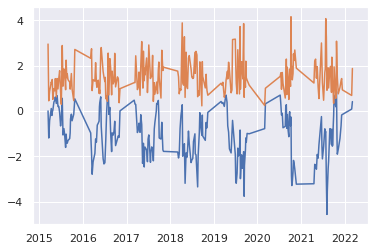

In [12]:
mod = sm.tsa.ARIMA(ts, order = (5,1,0))
res = mod.fit()
print(res.summary())

plt.plot(nyc_hist['date_formated'][1:], np.cumsum(res.predict()))
plt.plot(nyc_hist['date_formated'][1:], ts[1:])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.teamxgoals   No. Observations:                  243
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -278.002
Method:                       css-mle   S.D. of innovations              0.751
Date:                Thu, 10 Mar 2022   AIC                            572.004
Time:                        14:10:25   BIC                            599.948
Sample:                             1   HQIC                           583.260
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0011      0.001      1.575      0.117      -0.000       0.002
ar.L1.D.teamxgoals    -0.0061      0.064     -0.096      0.924      -0.132       0.120
ar.L2.D.teamxgoals  

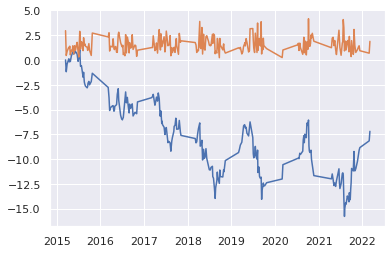

In [13]:
mod = sm.tsa.ARIMA(ts, order = (5,1,1))
res = mod.fit()
print(res.summary())

plt.plot(nyc_hist['date_formated'][1:], np.cumsum(res.predict()))
plt.plot(nyc_hist['date_formated'][1:], ts[1:])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


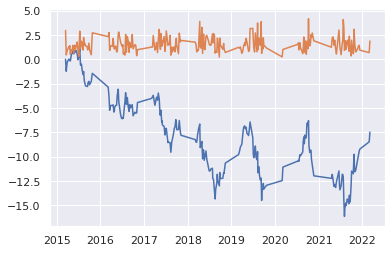

In [14]:
mod = sm.tsa.ARIMA(ts, order = (1,1,1))
res = mod.fit()

plt.plot(nyc_hist['date_formated'][1:], np.cumsum(res.predict()))
plt.plot(nyc_hist['date_formated'][1:], ts[1:])

In [15]:
print(res.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.teamxgoals   No. Observations:                  243
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -280.233
Method:                       css-mle   S.D. of innovations              0.758
Date:                Thu, 10 Mar 2022   AIC                            568.465
Time:                        14:10:26   BIC                            582.437
Sample:                             1   HQIC                           574.093
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0011      0.001      1.647      0.101      -0.000       0.002
ar.L1.D.teamxgoals    -0.0191      0.064     -0.298      0.766      -0.145       0.107
ma.L1.D.teamxgoals  

In [16]:
ts.rolling(5).mean()[5:]

117    1.34538
116    1.03290
240    1.04594
115    1.07084
239    0.99324
        ...   
124    1.32606
123    1.20654
122    1.09778
121    1.08344
120    1.24986
Name: teamxgoals, Length: 239, dtype: float64

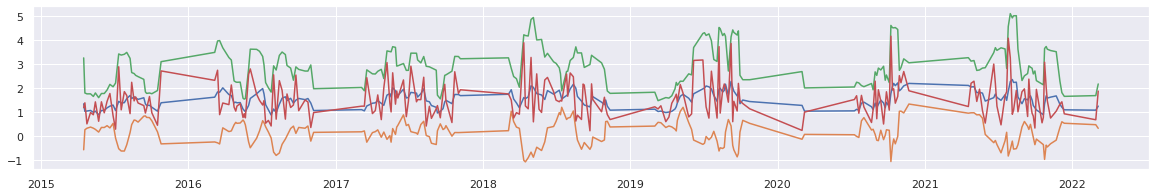

In [17]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(nyc_hist['date_formated'][5:],ts.rolling(5).mean()[5:])
plt.plot(nyc_hist['date_formated'][5:],ts.rolling(5).mean()[5:] - 2*ts.rolling(5).std()[5:])
plt.plot(nyc_hist['date_formated'][5:],ts.rolling(5).mean()[5:] + 2*ts.rolling(5).std()[5:])
plt.plot(nyc_hist['date_formated'][5:],ts[5:])

- given any game, I can compute the probabilities as follows:
    - compute the rolling mean and the rolling sd leading up to the game
    - create a simulation, in which for each instance, we do as follows 
        - create a normal rv with those parameters
        - simmulate the number of goals using a poisson process with that mean
    - we can use these simulations in two ways 
        - the first is to validate stuff 
            - create the distribution of goals and see if the histogram matches the histogram of actual goals 
            - create an histogram with the difference of the actual and predicted goals and make sure that it is centered normal looking
        - the second is to give distributions for the number of goals 
            - how do we validate these distributions?


In [60]:
nyc_hist.loc[:,'rolling mean'] = ts.rolling(5).mean()
nyc_hist.loc[:, 'rolling sd'] = ts.rolling(5).std()

def normal_with_nans(mean, sd):
    try:
        return np.random.normal(mean, sd)
    except:
        return np.nan

def poisson_with_nans(mean):
    try:
        return np.random.poisson(mean)
    except:
        return 0

normal_with_nans = np.vectorize(normal_with_nans)
poisson_with_nans = np.vectorize(poisson_with_nans)

nyc_hist.loc[:,'pred xgoals'] = normal_with_nans(nyc_hist.loc[:,'rolling mean'], nyc_hist.loc[:, 'rolling sd'])

nyc_hist.loc[:, 'pred goals'] = poisson_with_nans(nyc_hist['pred xgoals'])

nyc_hist

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2246: RuntimeWarning: invalid value encountered in poisson_with_nans (vectorized)
  outputs = ufunc(*inputs)


,teamgoals,teamxgoals,oppoxgoals,oppogoals,date_formated,rolling mean,rolling sd,rollingsd,pred xgoals,pred goals,pred goals enh
243,1,0.5261,0.5973,1,2015-03-08 21:00:00+00:00,NaN,NaN,NaN,NaN,0,NaN
119,2,2.9509,1.7539,0,2015-03-15 21:00:00+00:00,NaN,NaN,NaN,NaN,0,NaN
242,0,0.4476,1.1147,0,2015-03-21 20:00:00+00:00,NaN,NaN,NaN,NaN,0,NaN
118,0,0.8606,1.1757,1,2015-03-28 23:00:00+00:00,NaN,NaN,NaN,NaN,0,NaN
241,1,1.2791,1.8125,2,2015-04-11 20:00:00+00:00,1.21286,1.025490,1.025490,-0.658525,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
124,2,1.3306,1.2536,2,2021-12-01 00:30:00+00:00,1.32606,0.479614,0.479614,1.243663,1,1.0
123,2,1.4296,0.5437,0,2021-12-05 20:00:00+00:00,1.20654,0.303239,0.303239,1.518814,2,1.0
122,1,0.9313,1.4137,1,2021-12-11 20:00:00+00:00,1.09778,0.279421,0.279421,0.877361,0,1.0
121,0,0.6838,1.4804,1,2022-02-27 22:00:00+00:00,1.08344,0.302283,0.302283,1.213719,1,1.0


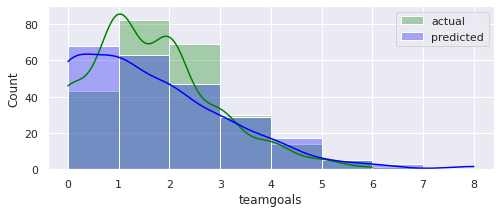

In [43]:
plt.rcParams["figure.figsize"] = (8,3)
sns.histplot(nyc_hist, x = 'teamgoals', bins= [0,1,2,3,4,5,6,7], color='green', alpha=0.3, label='actual', kde=True)
sns.histplot(nyc_hist, x = 'pred goals', bins= [0,1,2,3,4,5,6,7], color='blue', alpha=0.3, label ='predicted', kde=True)
plt.legend()

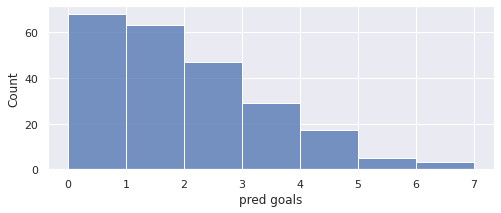

In [38]:
plt.rcParams["figure.figsize"] = (8,3)
sns.histplot(nyc_hist, x = 'pred goals', bins= [0,1,2,3,4,5,6,7])

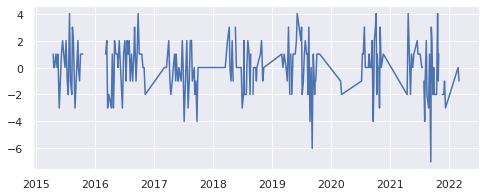

In [44]:
plt.plot(nyc_hist['date_formated'][5:], nyc_hist['teamgoals'][5:] - nyc_hist['pred goals'][5:])

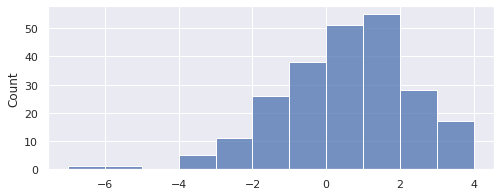

In [46]:
sns.histplot(nyc_hist['teamgoals'][5:] - nyc_hist['pred goals'][5:], bins=[x for x in range(-7, 5)])

So, the procedure sistematically underestimated. It also has way too much of a spread 

----

Am I underestimating the expected goals? Or is the Poisson distro underestimating the real goals? There is no reason to believe the first, must be the second

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2246: RuntimeWarning: invalid value encountered in poisson_with_nans (vectorized)
  outputs = ufunc(*inputs)


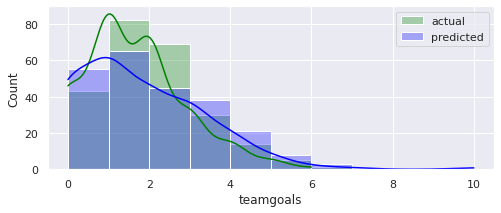

In [49]:
nyc_hist.loc[:, 'pred goals enh'] = poisson_with_nans(nyc_hist['pred xgoals']+0.25)

sns.histplot(nyc_hist, x = 'teamgoals', bins= [0,1,2,3,4,5,6,7], color='green', alpha=0.3, label='actual', kde=True)
sns.histplot(nyc_hist, x = 'pred goals enh', bins= [0,1,2,3,4,5,6,7], color='blue', alpha=0.3, label ='predicted', kde=True)
plt.legend()

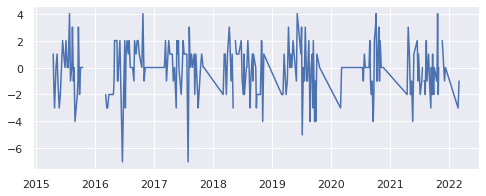

In [50]:
plt.plot(nyc_hist['date_formated'][5:], nyc_hist['teamgoals'][5:] - nyc_hist['pred goals enh'][5:])

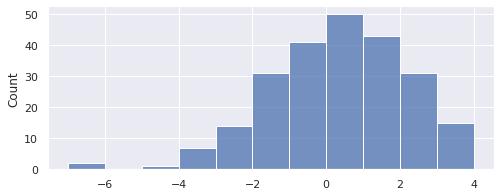

In [51]:
sns.histplot(nyc_hist['teamgoals'][5:] - nyc_hist['pred goals enh'][5:], bins=[x for x in range(-7, 5)])

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2246: RuntimeWarning: invalid value encountered in poisson_with_nans (vectorized)
  outputs = ufunc(*inputs)


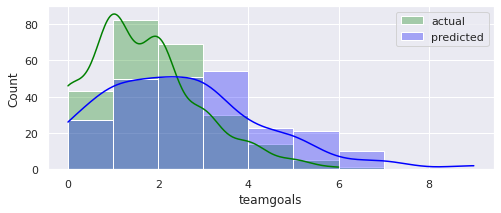

In [52]:
nyc_hist.loc[:, 'pred goals enh'] = poisson_with_nans(nyc_hist['pred xgoals']+1)

sns.histplot(nyc_hist, x = 'teamgoals', bins= [0,1,2,3,4,5,6,7], color='green', alpha=0.3, label='actual', kde=True)
sns.histplot(nyc_hist, x = 'pred goals enh', bins= [0,1,2,3,4,5,6,7], color='blue', alpha=0.3, label ='predicted', kde=True)
plt.legend()

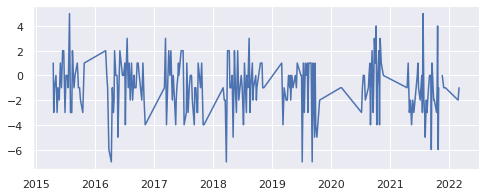

In [53]:
plt.plot(nyc_hist['date_formated'][5:], nyc_hist['teamgoals'][5:] - nyc_hist['pred goals enh'][5:])

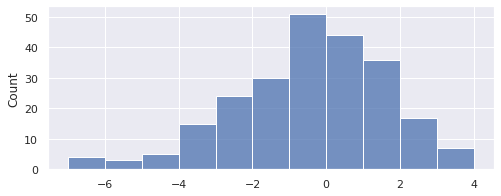

In [54]:
sns.histplot(nyc_hist['teamgoals'][5:] - nyc_hist['pred goals enh'][5:], bins=[x for x in range(-7, 5)])

In [61]:
nyc_hist.loc[:, 'pred goals enh'] = poisson_with_nans(nyc_hist['pred xgoals']+0.25)

nyc_hist

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2246: RuntimeWarning: invalid value encountered in poisson_with_nans (vectorized)
  outputs = ufunc(*inputs)


,teamgoals,teamxgoals,oppoxgoals,oppogoals,date_formated,rolling mean,rolling sd,rollingsd,pred xgoals,pred goals,pred goals enh
243,1,0.5261,0.5973,1,2015-03-08 21:00:00+00:00,NaN,NaN,NaN,NaN,0,0
119,2,2.9509,1.7539,0,2015-03-15 21:00:00+00:00,NaN,NaN,NaN,NaN,0,0
242,0,0.4476,1.1147,0,2015-03-21 20:00:00+00:00,NaN,NaN,NaN,NaN,0,0
118,0,0.8606,1.1757,1,2015-03-28 23:00:00+00:00,NaN,NaN,NaN,NaN,0,0
241,1,1.2791,1.8125,2,2015-04-11 20:00:00+00:00,1.21286,1.025490,1.025490,-0.658525,0,0
...,...,...,...,...,...,...,...,...,...,...,...
124,2,1.3306,1.2536,2,2021-12-01 00:30:00+00:00,1.32606,0.479614,0.479614,1.243663,1,1
123,2,1.4296,0.5437,0,2021-12-05 20:00:00+00:00,1.20654,0.303239,0.303239,1.518814,2,0
122,1,0.9313,1.4137,1,2021-12-11 20:00:00+00:00,1.09778,0.279421,0.279421,0.877361,0,1
121,0,0.6838,1.4804,1,2022-02-27 22:00:00+00:00,1.08344,0.302283,0.302283,1.213719,1,1


In [63]:
nyc_hist[nyc_hist['pred goals enh'].isnull()]

,teamgoals,teamxgoals,oppoxgoals,oppogoals,date_formated,rolling mean,rolling sd,rollingsd,pred xgoals,pred goals,pred goals enh


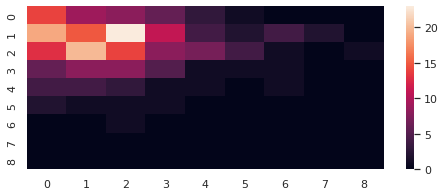

In [64]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(nyc_hist['teamgoals'][5:], nyc_hist['pred goals enh'][5:]))

It's not great.

Making predictions is hard, specially about the future. 